In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import rc

import numpy as np

from scipy.constants import speed_of_light
from scipy.fft import fft, fftfreq
from scipy.fftpack import ifft, idct, dct
import scipy.fftpack as spfft
import cvxpy as cvx

# LaTeX type definitions
rc('font', **{'family': 'sans serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=True)

In [2]:
# Run this cell if you need to install TeX for plots 

!sudo apt-get install texlive-latex-recommended 
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
!wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
!unzip type1cm.zip -d /tmp/type1cm 
!cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
!sudo mkdir /usr/share/texmf/tex/latex/type1cm 
!sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
!sudo texhash

!apt install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-d

In [3]:
def channel_model(bs_gain, bs_pos,
                  ue_gain, ue_pos,
                  ris_size_el, ris_num_els_hor, ris_num_els_ver, ris_configs):
    """Get Downlink (DL) and Uplink (UL) channel gain.

    Returns
    -------
    channel_gains_dl : ndarray of shape (num_configs, num_ues)
        Downlink channel gain between the BS and each UE for each RIS configuration.

    channel_gains_ul : ndarray of shape (num_configs, num_ues)
        Uplink channel gain between the BS and each UE for each RIS configuration.

    """

    # Extract distances and angles
    bs_distance = np.linalg.norm(bs_pos)
    bs_angle = np.arctan2(bs_pos[0], bs_pos[1])

    ue_distances = np.linalg.norm(ue_pos, axis=0)
    ue_angles = np.arctan2(ue_pos[0, :], ue_pos[1, :])

    # Compute constant term
    num = bs_gain * ue_gain * (ris_size_el * ris_size_el)**2
    den = (4 * np.pi * bs_distance * ue_distances)**2

    const = num/den
    
    # Compute DL pathloss component of shape (num_ues, )
    pathloss_dl = const * np.cos(bs_angle)**2

    # Compute UL pathloss component of shape (num_ues, )
    pathloss_ul = const * np.cos(ue_angles)**2

    # Compute constant phase component of shape (num_ues, )
    distances_sum = (bs_distance + ue_distances)
    disagreement = (np.sin(bs_angle) - np.sin(ue_angles)) * ((ris_num_els_hor + 1) / 2) * ris_size_el

    phi = - wavenumber * (distances_sum - disagreement)
    
    # Compute array factor of shape (num_configs, num_ues)
    enumeration_num_els_x = np.arange(1, ris_num_els_hor + 1)
    sine_differences = (np.sin(ue_angles[np.newaxis, :, np.newaxis]) - np.sin(ris_configs[:, np.newaxis, np.newaxis]))

    argument = wavenumber * sine_differences * enumeration_num_els_x[np.newaxis, np.newaxis, :] * ris_size_el

    array_factor_dl = ris_num_els_ver * np.sum(np.exp(+1j * argument), axis=-1)
    array_factor_ul = array_factor_dl.conj()

    # Compute channel gains of shape (num_configs, num_ues)
    channel_gains_dl = np.sqrt(pathloss_dl[np.newaxis, :]) * np.exp(+1j * phi[np.newaxis, :]) * array_factor_dl
    channel_gains_ul = np.sqrt(pathloss_ul[np.newaxis, :]) * np.exp(-1j * phi[np.newaxis, :]) * array_factor_ul

    return channel_gains_dl, channel_gains_ul
    

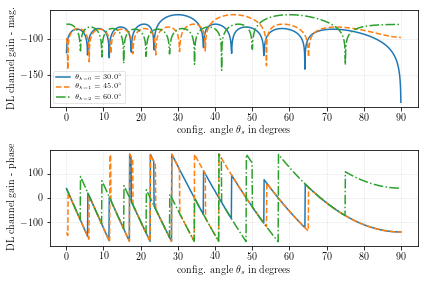

In [4]:
########################################
# Parameters
########################################

#-----
# Eletromagnetics
#-----

# Signal
carrier_frequency = 3e9
wavelength = speed_of_light / carrier_frequency
wavenumber = 2 * np.pi / wavelength

# Distances
#maximum_distance = 100

# Noise
noise_power = 10 ** (-94.0 / 10)  # mW

#-----
# RIS
#-----

# Number of configurations
ris_num_configs = 1001

# Number of elements
ris_num_els_ver = ris_num_els_hor = 10  # vertical/horizontal

# Size of each element
ris_size_el = wavelength

# RIS size along one of the dimensions
ris_size = ris_num_els_ver * ris_size_el

# RIS configurations
ris_angular_resolution = ((np.pi / 2) - 0) / ris_num_configs
ris_configs = np.arange(ris_angular_resolution / 2, np.pi / 2, ris_angular_resolution)

# Minimum distant to RIS
minimum_distance = (2/wavelength) * ris_size**2

#-----
# BS
#-----

# BS antenna gain
bs_gain = 10**(5/10)

# Position
bs_angle = np.deg2rad([-45.0])
bs_pos = minimum_distance * np.array([np.sin(bs_angle), np.cos(bs_angle)])

#-----
# UE
#-----

# UE antenna gain
ue_gain = 10**(5/10)

# Define specific positions for the UEs
ue_angles_deg = np.array([30.0, 45.0, 60.0])
#ue_angles_deg = np.array([45.0])
ue_angles = np.deg2rad(ue_angles_deg)

# Prepare to save UE positions
ue_pos = np.zeros((3, ue_angles_deg.size))

# Compute UE positions
ue_pos[0, :] = np.sin(ue_angles)
ue_pos[1, :] = np.cos(ue_angles)

ue_pos *= minimum_distance

# Get channel gains for the UEs
channel_gains_dl, channel_gains_ul = channel_model(bs_gain, bs_pos, ue_gain, ue_pos, ris_size_el, ris_num_els_hor, ris_num_els_ver, ris_configs)

# Plot channel gain vs number of configurations 
fig, axes = plt.subplots(2, 1)

# Create a marker vector
markers = ['-', '--', '-.', ':']

# Go through all UEs
for ue in range(ue_angles_deg.size):

    label = r'$\theta_{k=' + str(ue) + '} =' + str(np.round(ue_angles_deg[ue], 2)) + '^{\circ}$'

    axes[0].plot(np.rad2deg(ris_configs), 20*np.log10(np.abs(channel_gains_dl[:, ue])), markers[ue], label=label)
    axes[1].plot(np.rad2deg(ris_configs), np.rad2deg(np.angle(channel_gains_dl[:, ue])), markers[ue])

axes[0].set_xlabel(r'config. angle $\theta_s$ in degrees')
axes[1].set_xlabel(r'config. angle $\theta_s$ in degrees')

axes[0].set_ylabel('DL channel gain - mag.')
axes[1].set_ylabel('DL channel gain - phase')

axes[0].set_xticks(np.arange(0, 100, 10))
axes[1].set_xticks(np.arange(0, 100, 10))

axes[0].legend(fontsize='x-small', framealpha=0.5)

axes[0].grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
axes[1].grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

plt.tight_layout()

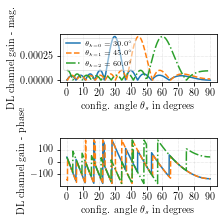

In [7]:
# Plot channel gain vs number of configurations 
fig, axes = plt.subplots(figsize=(3.15, 3), nrows=2, ncols=1)

# Create a marker vector
markers = ['-', '--', '-.', ':']

# Go through all UEs
for ue in range(ue_angles_deg.size):

    label = r'$\theta_{k=' + str(ue) + '} =' + str(np.round(ue_angles_deg[ue], 2)) + '^{\circ}$'

    axes[0].plot(np.rad2deg(ris_configs), (np.abs(channel_gains_dl[:, ue])), markers[ue], label=label)
    axes[1].plot(np.rad2deg(ris_configs), np.rad2deg(np.angle(channel_gains_dl[:, ue])), markers[ue])

axes[0].set_xlabel(r'config. angle $\theta_s$ in degrees')
axes[1].set_xlabel(r'config. angle $\theta_s$ in degrees')

axes[0].set_ylabel('DL channel gain - mag.')
axes[1].set_ylabel('DL channel gain - phase')

axes[0].set_xticks(np.arange(0, 100, 10))
axes[1].set_xticks(np.arange(0, 100, 10))

axes[0].legend(fontsize='x-small', framealpha=0.5)

axes[0].grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
axes[1].grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

plt.tight_layout()

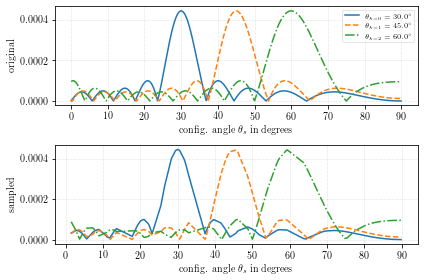

In [5]:
# Focus on the magnitude of the signal 
abs_channel_gains_dl = np.abs(channel_gains_dl)

# Define number of sampling points
num_samples = 101 #int(0.01 * ris_num_configs)

# Random sampling indexes
random_indexes = np.random.choice(ris_num_configs, num_samples, replace=False)
random_indexes.sort()

# Performing sampling
sampled_channel_gains_dl = abs_channel_gains_dl[random_indexes, :]

# Plot samples signal against original one
fig, axes = plt.subplots(2, 1)

# Create a marker vector
markers = ['-', '--', '-.', ':']

# Go through all UEs
for ue in range(ue_angles_deg.size):

    label = r'$\theta_{k=' + str(ue) + '} =' + str(np.round(ue_angles_deg[ue], 2)) + '^{\circ}$'

    axes[0].plot(np.rad2deg(ris_configs), (np.abs(channel_gains_dl[:, ue])), markers[ue], label=label)
    axes[1].plot(np.rad2deg(ris_configs)[random_indexes], (np.abs(sampled_channel_gains_dl[:, ue])), markers[ue])

axes[0].set_xlabel(r'config. angle $\theta_s$ in degrees')
axes[1].set_xlabel(r'config. angle $\theta_s$ in degrees')

axes[0].set_ylabel('original')
axes[1].set_ylabel('sampled')

axes[0].set_xticks(np.arange(0, 100, 10))
axes[1].set_xticks(np.arange(0, 100, 10))

axes[0].legend(fontsize='x-small', framealpha=0.5)

axes[0].grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
axes[1].grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

plt.tight_layout()